## Logistic Regression

In [1]:
# отключение ворнингов
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import (train_test_split, cross_val_score, learning_curve,
                                     validation_curve, GridSearchCV)
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, plot_roc_curve
from tqdm import tqdm

In [2]:
# настройка размеров графиков
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 8)

# настройка стиля графиков
plt.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


In [3]:
# читаем данные
df = pd.read_csv('./data/adult_train.csv', sep=';')

# выведу для проверки
df.head(5)

,Age,Workclass,fnlwgt,Education,Education_Num,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## Подготовка данных

In [4]:
# закодирую целевую перменную
df['Target'] = df['Target'].map({' <=50K': 0, ' >50K': 1})

# категориальные переменные
cat_features = df.columns[df.dtypes == 'object']

# OHE для категориальных переменных
df = pd.get_dummies(df, columns=cat_features)

print(f'Размерность датасета с OHE и попарными взаимодействиями: {df.shape}')

Размерность датасета с OHE и попарными взаимодействиями: (32561, 106)


In [5]:
# отделю таргет и признаки
X = df.drop('Target', axis=1)
y = df['Target']

# воспроизводимость
rs = np.random.seed(0)
    
# разобью данные на трейн и тест
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=rs, stratify=y)
       
print('Доля положительных примеров в трейне: {:.4f}'.format(np.mean(y_train)), end='\n\n')
print('Доля положительных примеров в тесте: {:.4f}'.format(np.mean(y_test)))

Доля положительных примеров в трейне: 0.2408

Доля положительных примеров в тесте: 0.2408


In [6]:
# стандартизация данных
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Обучение модели

In [7]:
def cross_validation(classifier, X_train, y_train, cv=3, scoring='accuracy'):
    # название модели для красивого вывода
    clf_name = str(classifier)
    clf_name = clf_name[:clf_name.index('(')]
    cv_scores = cross_val_score(classifier, X_train, y_train, scoring=scoring, cv=cv)
    print('Среднее значение \033[1m{}\033[0m для {} на валидации: \033[1m{:.4f}\033[0m'.format(
        scoring, clf_name, np.mean(cv_scores)))
    
def fit_evaluate(classifier, X_train, X_test, y_train, y_test, metric=accuracy_score):
    # название модели для красивого вывода
    clf_name = str(classifier)
    clf_name = clf_name[:clf_name.index('(')]
    
    # название метрики 
    metric_name = str(metric)
    metric_name = metric_name[metric_name.index(' ')+1:metric_name.index(' at')]
    classifier.fit(X_train, y_train)
    predictions = classifier.predict_proba(X_test)[:, 1]
    print('Среднее значение \033[1m{}\033[0m для {} на отложенной выборке: \033[1m{:.4f}\033[0m'.format(
        metric_name, clf_name, metric(y_test, predictions)))

In [8]:
# логистическая регрессия

logit = LogisticRegression(random_state=rs)

cross_validation(logit, X_train, y_train, cv=5, scoring='roc_auc')
fit_evaluate(logit, X_train, X_test, y_train, y_test, metric=roc_auc_score)

Среднее значение roc_auc для LogisticRegression на валидации: 0.9056
Среднее значение roc_auc_score для LogisticRegression на отложенной выборке: 0.9050


In [9]:
# случайный лес 

rf = RandomForestClassifier(random_state=rs)

cross_validation(rf, X_train, y_train, cv=5, scoring='roc_auc')
fit_evaluate(rf, X_train, X_test, y_train, y_test, metric=roc_auc_score)

Среднее значение roc_auc для RandomForestClassifier на валидации: 0.9009
Среднее значение roc_auc_score для RandomForestClassifier на отложенной выборке: 0.9028


Качество логистической регрессии сопоставимо со случайным лесом, при том, что логрег обучается быстрее.

## Подбор гиперпараметров для логистической регрессии

Буду подбирать параметры регуляризации:
- регуляризатор l1 или l2 норма
- C- 1/коэффициент регуляризации

In [10]:
logit_params = dict(penalty=['l1', 'l2'],
                    C=np.logspace(-2, 0, 200)
                )

logit_cv = GridSearchCV(estimator=logit, param_grid=logit_params, 
                             cv=5, n_jobs=-1, verbose=False)

logit_cv.fit(X_train, y_train)
best_logit = logit_cv.best_estimator_

preds = best_logit.predict_proba(X_test)[:, 1]
score = roc_auc_score(y_test, preds)
print(f'ROC-AUC для DT {score:.4f}', end='\n\n')
print(classification_report(y_test, np.where(preds>0.5, 1, 0)))

ROC-AUC для DT 0.9051

              precision    recall  f1-score   support

           0       0.88      0.93      0.90      7417
           1       0.73      0.59      0.65      2352

    accuracy                           0.85      9769
   macro avg       0.80      0.76      0.78      9769
weighted avg       0.84      0.85      0.84      9769



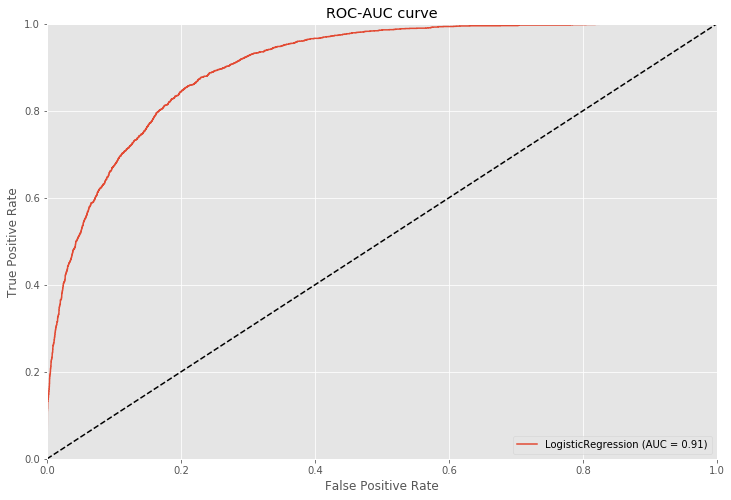

In [11]:
# roc кривая для logit

plot_roc_curve(best_logit, X_test, y_test)
plt.title('ROC-AUC curve')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

## Кривая обучения

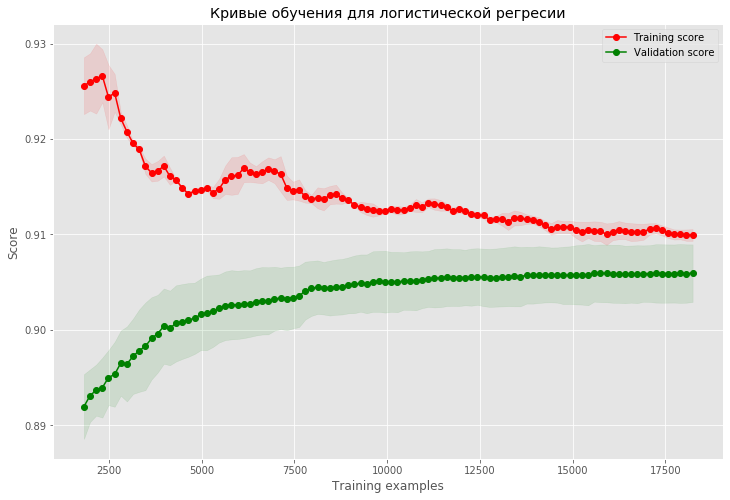

In [12]:
# построю кривые обучения

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 20)):
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='roc_auc')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r',
             label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g',
             label='Validation score')

    plt.legend(loc="best")
    return plt


plot_learning_curve(best_logit, 'Кривые обучения для логистической регресии', X_train, y_train,
                    train_sizes=np.linspace(.1, 1.0, 100), cv=5, n_jobs=-1);

Валидационная кривая выходит на плато, кажется, что новые данные не сильно помогут.

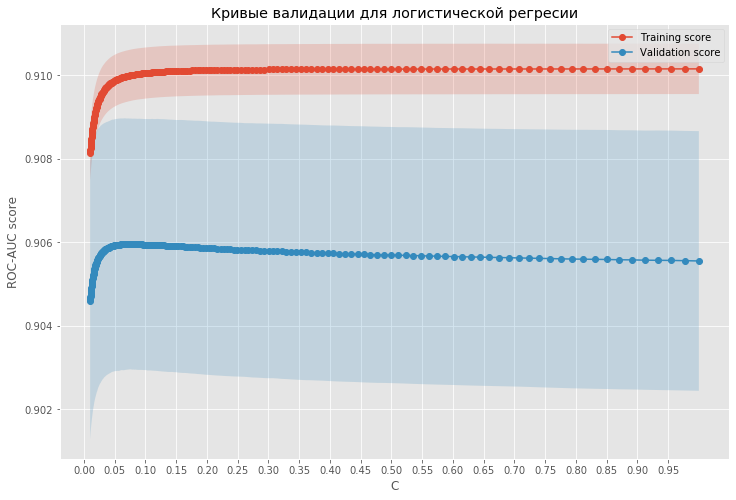

In [13]:
# построю кривые валидации

def plot_with_err(param, data, **kwargs):
    """
    Строит кривые валидации
    """
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(param, mu, 'o-', **kwargs)
    plt.fill_between(param, mu - std, mu + std, edgecolor='none',
                     facecolor=lines[0].get_color(), alpha=0.2)
    
    
C = np.logspace(-2, 0, 200)
val_train, val_test = validation_curve(best_logit, X_train, y_train,
                                       'C', C, cv=5,
                                        scoring='roc_auc', n_jobs=-1)


plot_with_err(C, val_train, label='Training score')
plot_with_err(C, val_test, label='Validation score')
plt.xlabel('С'); plt.ylabel('ROC-AUC score')
plt.xticks(np.arange(0, 1, 0.05))
plt.title('Кривые валидации для логистической регресии')
plt.legend();

In [14]:
print(best_logit)

LogisticRegression(C=0.05941133984965034, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


## Отбор признаков

Отбор признаков простым перебором.

In [15]:
def feature_selector(estimator, X_train, X_test, y_train, y_test):
    """
    Simple feature selector
    :param estimator: sklearn like eatimator
    :param X_train: pandas DataFrame
    :param X_test: pandas DataFrame
    :param y_train: pandas Series
    :param y_test: pandas Series
    """
    # формируем список признаков
    features = list(X_train.columns)
    estimator.fit(X_train, y_train)
    preds = estimator.predict_proba(X_test)[:, 1]
    
    # сохраняем результат на всех фичах
    best_score = roc_auc_score(y_test, preds)
    
    best_features = features.copy()
    for column in tqdm(features):
        if column in best_features:
            best_features.remove(column)
            estimator.fit(X_train[best_features], y_train)
            preds = estimator.predict_proba(X_test[best_features])[:, 1]
            score = roc_auc_score(y_test, preds)
            
            # если результат ухудшился, возвращаем признак в список
            if score < best_score:
                best_features.append(column)
            else:
                best_score = score
    print(f'Best score is {best_score:.4f}')
    
    return estimator, best_features

In [16]:
# приведем признаки обратно к пандас для удобства работы с признаками
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

best_logit, best_features = feature_selector(best_logit, X_train, X_test, y_train, y_test)

100%|██████████| 105/105 [00:22<00:00,  4.61it/s]

Best score is 0.9070


Результат немного улучшился.